#### Reading the data we prepared:

In [109]:
import pandas as pd, numpy as np
np.random.seed(42) 

data_source = '../cleaned_Airline_Delay_Data.csv'
df = pd.read_csv(data_source)
X = df.drop(columns=['arr_del15']) # establish feature set
y = df['arr_del15'] # establish target array

print(f"Data shape: {X.shape}") 
print(f"Features: {len(X.columns)}")

Data shape: (171223, 35)
Features: 35


#### **I have chosen CatBoost (Boosting Algorithm) and a Tree-Based Regressor (RandomForestRegressor: Bagging algorithm)**  to try out as the features carry non-linear relationships with our continuous target, and the dataset contains rich categorical columns that we had to strip of some signal (like airport_name). 
#### We could certainly test out many models, with all their hyperparameters, and different feature sets.. **if we have the time and capacity for it.** In real-time production, this is not ideal, but **it certainly can be for research.**
#### **For this reason, I will need to decide which features stay and which get dropped, as well as keep rich categorical features for CatBoost (which natively handles categorical columns) aside.**

In [110]:
print(f"\nCategorical columns for catboost: {X.select_dtypes(include='object').columns.tolist()}")
print(f"Numeric columns: {len(X.select_dtypes(exclude='object').columns)}")


Categorical columns for catboost: ['carrier_name', 'airport_name']
Numeric columns: 33


C:\Users\User\AppData\Local\Temp\ipykernel_17424\933727400.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  print(f"\nCategorical columns for catboost: {X.select_dtypes(include='object').columns.tolist()}")


In [111]:
# I will split X and y into training and test sets according to years as this is time-series data. 
# this datasets spans 10 years so we train with 7, test with 3 years of data.
train_mask = X['year'] <= 2020
X_train, y_train = X[train_mask], y[train_mask]

test_mask = X['year'] > 2020
X_test, y_test = X[test_mask], y[test_mask]

#### In the previous notebook, I kept many features, but it’s often **better to select the most predictive ones rather than using all features blindly, as this reduces noise and improves efficiency**.
Firstly, remove collinearity

In [112]:
from feature_engine.selection import DropCorrelatedFeatures

# Remember, correlation assumes numeric columns. 
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['year']]

print(f"Checking correlation for {len(num_cols)} numeric features...")

tr = DropCorrelatedFeatures(variables=num_cols, method='pearson', threshold=0.8)
Xt = tr.fit_transform(X_train[num_cols])

if len(tr.correlated_feature_sets_) > 0:
    print(f"\nFound {len(tr.correlated_feature_sets_)} correlated feature sets:")
    for feature_set in tr.correlated_feature_sets_:
        print(f"  - {feature_set}")
else:
    print("No highly correlated features (threshold=0.8)")

Checking correlation for 32 numeric features...
No highly correlated features (threshold=0.8)


#### --> It seems **none of our features are too *linearly* correlated.**

#### Following our EDA, we created two airport encoding strategies:
- **Atlanta only**: Binary feature for highest-importance airport
- **Top 5**: Binary feature for top 5 airports by importance

Let's test which performs better using baseline Random Forest.

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# For all non CatBoost models, categorical columns must be dropped. I will determine the set of features for CatBoost 
#  depending on our results at this stage.

X_train_non_cat = X_train.drop(columns=['airport_name','carrier_name'])
X_test_non_cat = X_test.drop(columns=['airport_name','carrier_name'])

# Define all datasets with varying features to train and evaluate all 3.
X_train_atlanta = X_train_non_cat.drop(columns= ['is_top5'])
X_testatlanta = X_test_non_cat.drop(columns= ['is_top5'])

X_train_top5 = X_train_non_cat.drop(columns= ['is_GA_Atlanta'])
X_testtop5 = X_test_non_cat.drop(columns= ['is_GA_Atlanta'])

X_train_both = X_train_non_cat.copy(deep=True)
X_testboth = X_test_non_cat.copy(deep=True)

results = {}

for name, X_tr, X_te in [
    ('Atlanta_only', X_train_atlanta, X_testatlanta),
    ('Top5_only', X_train_top5, X_testtop5),
    ('Both', X_train_both, X_testboth)
]:
    print(f"Training with {name}... ({X_tr.shape[1]} features)", end=' ')

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=12,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr, y_train)
    
    train_pred = model.predict(X_tr)
    test_pred = model.predict(X_te)
    
    # Store results of each
    results[name] = {
        'Train_R2': r2_score(y_train, train_pred),
        'Test_R2': r2_score(y_test, test_pred),
        'MAE': mean_absolute_error(y_test, test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, test_pred))
    }
    print(f"Test R² = {results[name]['Test_R2']:.4f}")

results_df = pd.DataFrame(results).T
print("AIRPORT ENCODING COMPARISON: Random Forest Baseline \n")
print(results_df.round(4))

best_strategy = results_df['Test_R2'].idxmax()
print(f"\n Best strategy: {best_strategy} (R² = {results_df.loc[best_strategy, 'Test_R2']:.4f})")

if best_strategy == 'Atlanta_only':
    X_train_non_cat = X_train_non_cat.drop(columns=['is_top5'])
    X_test_non_cat = X_test_non_cat.drop(columns=['is_top5'])

elif best_strategy == 'Top5_only':
    X_train_non_cat = X_train_non_cat.drop(columns=['is_GA_Atlanta'])
    X_test_non_cat = X_test_non_cat.drop(columns=['is_GA_Atlanta'])
else:
    pass

Training with Atlanta_only... (32 features) Test R² = 0.8089
Training with Top5_only... (32 features) Test R² = 0.7971
Training with Both... (33 features) Test R² = 0.8012
AIRPORT ENCODING COMPARISON: Random Forest Baseline 

              Train_R2  Test_R2      MAE     RMSE
Atlanta_only    0.9500   0.8089  25.3420  78.6362
Top5_only       0.9525   0.7971  25.7288  81.0308
Both            0.9526   0.8012  25.5581  80.2153

 Best strategy: Atlanta_only (R² = 0.8089)


In [114]:
# Now we can more confidently define CatBoost's feature set.
cat_boost_cols = ['year', 'carrier_name', 'airport_name', 'arr_flights', 'isCovid', 'isPeakSeason', 
                  'isLowSeason', 'is_holiday', 'month_sin', 'month_cos', 'is_GA_Atlanta']

#### **Most Predictive: Atlanta Only**. This validates our statistical analysis from the EDA notebook. The importance scores correctly identified which airports contribute most to predictive performance.
#### Generally, you could make the arguement that different parameters of Random Forest / an alternative regressor could've yielded better results with 'both' or 'top5 only', and this is definitely something we could later on revisit if need be. Extensive experimentation is a big part of our job as data scientists / ML specialists.

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

print(f"Optimizing with {best_strategy} strategy ({X_train.shape[1]} features)")

def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 8, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 4, 20),
        'max_features': trial.suggest_float('max_features', 0.3, 0.9),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestRegressor(**params)
    
    scores = cross_val_score(
        model, X_train_non_cat, y_train,
        cv=3, scoring='r2', n_jobs=-1
    )
    
    return scores.mean()

print("\n" + "="*70)
print("HYPERPARAMETER OPTIMIZATION")
print("="*70)

print("\n1. Optimizing Random Forest...")
rf_study = optuna.create_study(direction='maximize', study_name='RandomForest')
rf_study.optimize(rf_objective, n_trials=30, show_progress_bar=True)


print(f"\nBest RF CV R²: {rf_study.best_value:.4f}")
print(f"Best params: {rf_study.best_params}")

[I 2026-01-30 13:53:52,652] A new study created in memory with name: RandomForest


Optimizing with Atlanta_only strategy (35 features)

HYPERPARAMETER OPTIMIZATION

1. Optimizing Random Forest...


Best trial: 0. Best value: 0.846158:   3%|▎         | 1/30 [00:08<04:20,  8.98s/it]

[I 2026-01-30 13:54:01,634] Trial 0 finished with value: 0.8461583965332045 and parameters: {'n_estimators': 208, 'max_depth': 9, 'min_samples_split': 47, 'min_samples_leaf': 15, 'max_features': 0.3138000768927541}. Best is trial 0 with value: 0.8461583965332045.


Best trial: 1. Best value: 0.864811:   7%|▋         | 2/30 [00:31<07:50, 16.79s/it]

[I 2026-01-30 13:54:23,900] Trial 1 finished with value: 0.8648112009790822 and parameters: {'n_estimators': 191, 'max_depth': 16, 'min_samples_split': 28, 'min_samples_leaf': 13, 'max_features': 0.6894306071695703}. Best is trial 1 with value: 0.8648112009790822.


Best trial: 2. Best value: 0.8662:  10%|█         | 3/30 [00:43<06:35, 14.63s/it]  

[I 2026-01-30 13:54:35,963] Trial 2 finished with value: 0.8661998231593926 and parameters: {'n_estimators': 210, 'max_depth': 15, 'min_samples_split': 24, 'min_samples_leaf': 4, 'max_features': 0.47522780371804263}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  13%|█▎        | 4/30 [00:50<05:08, 11.85s/it]

[I 2026-01-30 13:54:43,545] Trial 3 finished with value: 0.8560179601053393 and parameters: {'n_estimators': 101, 'max_depth': 12, 'min_samples_split': 36, 'min_samples_leaf': 17, 'max_features': 0.34962750498486456}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  17%|█▋        | 5/30 [00:59<04:30, 10.83s/it]

[I 2026-01-30 13:54:52,581] Trial 4 finished with value: 0.8560192895189213 and parameters: {'n_estimators': 182, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': 0.3160232458318403}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  20%|██        | 6/30 [01:07<03:52,  9.70s/it]

[I 2026-01-30 13:55:00,091] Trial 5 finished with value: 0.8622819570606358 and parameters: {'n_estimators': 140, 'max_depth': 18, 'min_samples_split': 46, 'min_samples_leaf': 14, 'max_features': 0.4606047229376648}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  23%|██▎       | 7/30 [01:14<03:22,  8.79s/it]

[I 2026-01-30 13:55:07,004] Trial 6 finished with value: 0.8644402946893507 and parameters: {'n_estimators': 156, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': 0.631315555721661}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  27%|██▋       | 8/30 [01:27<03:40, 10.03s/it]

[I 2026-01-30 13:55:19,674] Trial 7 finished with value: 0.863087436370724 and parameters: {'n_estimators': 229, 'max_depth': 12, 'min_samples_split': 22, 'min_samples_leaf': 18, 'max_features': 0.699866638740444}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  30%|███       | 9/30 [01:46<04:34, 13.06s/it]

[I 2026-01-30 13:55:39,398] Trial 8 finished with value: 0.8641831066317107 and parameters: {'n_estimators': 264, 'max_depth': 16, 'min_samples_split': 21, 'min_samples_leaf': 15, 'max_features': 0.8021645361946432}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  33%|███▎      | 10/30 [01:58<04:12, 12.62s/it]

[I 2026-01-30 13:55:51,049] Trial 9 finished with value: 0.8650253801161227 and parameters: {'n_estimators': 225, 'max_depth': 19, 'min_samples_split': 46, 'min_samples_leaf': 4, 'max_features': 0.5498835566468341}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  37%|███▋      | 11/30 [02:10<03:54, 12.36s/it]

[I 2026-01-30 13:56:02,820] Trial 10 finished with value: 0.8657509494801504 and parameters: {'n_estimators': 295, 'max_depth': 14, 'min_samples_split': 34, 'min_samples_leaf': 4, 'max_features': 0.4752949890331696}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  40%|████      | 12/30 [02:27<04:09, 13.88s/it]

[I 2026-01-30 13:56:20,150] Trial 11 finished with value: 0.865772383828617 and parameters: {'n_estimators': 299, 'max_depth': 14, 'min_samples_split': 34, 'min_samples_leaf': 4, 'max_features': 0.4826308047906202}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  43%|████▎     | 13/30 [02:41<03:55, 13.86s/it]

[I 2026-01-30 13:56:33,981] Trial 12 finished with value: 0.8652882849863487 and parameters: {'n_estimators': 290, 'max_depth': 15, 'min_samples_split': 28, 'min_samples_leaf': 8, 'max_features': 0.48236748917775263}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 2. Best value: 0.8662:  47%|████▋     | 14/30 [02:50<03:19, 12.48s/it]

[I 2026-01-30 13:56:43,283] Trial 13 finished with value: 0.8623293683722403 and parameters: {'n_estimators': 240, 'max_depth': 13, 'min_samples_split': 40, 'min_samples_leaf': 7, 'max_features': 0.4256052761628106}. Best is trial 2 with value: 0.8661998231593926.


Best trial: 14. Best value: 0.866704:  50%|█████     | 15/30 [03:04<03:14, 12.98s/it]

[I 2026-01-30 13:56:57,413] Trial 14 finished with value: 0.8667037599801185 and parameters: {'n_estimators': 259, 'max_depth': 17, 'min_samples_split': 26, 'min_samples_leaf': 7, 'max_features': 0.5620854703580748}. Best is trial 14 with value: 0.8667037599801185.


Best trial: 14. Best value: 0.866704:  53%|█████▎    | 16/30 [03:20<03:12, 13.72s/it]

[I 2026-01-30 13:57:12,858] Trial 15 finished with value: 0.8662772586556565 and parameters: {'n_estimators': 267, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.5739529099835423}. Best is trial 14 with value: 0.8667037599801185.


Best trial: 14. Best value: 0.866704:  57%|█████▋    | 17/30 [03:45<03:41, 17.07s/it]

[I 2026-01-30 13:57:37,717] Trial 16 finished with value: 0.8649811543995335 and parameters: {'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.8932846875750954}. Best is trial 14 with value: 0.8667037599801185.


Best trial: 17. Best value: 0.867059:  60%|██████    | 18/30 [04:01<03:23, 17.00s/it]

[I 2026-01-30 13:57:54,540] Trial 17 finished with value: 0.8670589306273252 and parameters: {'n_estimators': 263, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.5790435441847089}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 17. Best value: 0.867059:  63%|██████▎   | 19/30 [04:20<03:11, 17.44s/it]

[I 2026-01-30 13:58:13,008] Trial 18 finished with value: 0.8669859144113653 and parameters: {'n_estimators': 255, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 0.6370523370069892}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 17. Best value: 0.867059:  67%|██████▋   | 20/30 [04:37<02:52, 17.25s/it]

[I 2026-01-30 13:58:29,830] Trial 19 finished with value: 0.8666071540888579 and parameters: {'n_estimators': 233, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 0.6650095189979351}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 17. Best value: 0.867059:  70%|███████   | 21/30 [04:54<02:36, 17.42s/it]

[I 2026-01-30 13:58:47,644] Trial 20 finished with value: 0.8653074596565397 and parameters: {'n_estimators': 245, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 0.743024389675301}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 17. Best value: 0.867059:  73%|███████▎  | 22/30 [05:09<02:12, 16.59s/it]

[I 2026-01-30 13:59:02,284] Trial 21 finished with value: 0.8666922159535652 and parameters: {'n_estimators': 274, 'max_depth': 18, 'min_samples_split': 25, 'min_samples_leaf': 6, 'max_features': 0.5546231770181103}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 17. Best value: 0.867059:  77%|███████▋  | 23/30 [05:23<01:51, 15.91s/it]

[I 2026-01-30 13:59:16,606] Trial 22 finished with value: 0.8658983908809263 and parameters: {'n_estimators': 247, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 0.6157441052743114}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 17. Best value: 0.867059:  80%|████████  | 24/30 [05:45<01:45, 17.55s/it]

[I 2026-01-30 13:59:37,992] Trial 23 finished with value: 0.8662971661717754 and parameters: {'n_estimators': 279, 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 0.7617156838312511}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 17. Best value: 0.867059:  83%|████████▎ | 25/30 [05:59<01:22, 16.42s/it]

[I 2026-01-30 13:59:51,786] Trial 24 finished with value: 0.8667258972787285 and parameters: {'n_estimators': 254, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 0.5324893823567267}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 17. Best value: 0.867059:  87%|████████▋ | 26/30 [06:08<00:56, 14.20s/it]

[I 2026-01-30 14:00:00,793] Trial 25 finished with value: 0.8639164828220763 and parameters: {'n_estimators': 219, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 0.4038529264804662}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 17. Best value: 0.867059:  90%|█████████ | 27/30 [06:38<00:57, 19.01s/it]

[I 2026-01-30 14:00:31,015] Trial 26 finished with value: 0.8605026338956655 and parameters: {'n_estimators': 253, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 20, 'max_features': 0.5179421128297432}. Best is trial 17 with value: 0.8670589306273252.


Best trial: 27. Best value: 0.867252:  93%|█████████▎| 28/30 [06:48<00:32, 16.48s/it]

[I 2026-01-30 14:00:41,601] Trial 27 finished with value: 0.8672516995358688 and parameters: {'n_estimators': 173, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.6340343742894552}. Best is trial 27 with value: 0.8672516995358688.


Best trial: 27. Best value: 0.867252:  97%|█████████▋| 29/30 [06:59<00:14, 14.81s/it]

[I 2026-01-30 14:00:52,511] Trial 28 finished with value: 0.8670500012438426 and parameters: {'n_estimators': 169, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 0.6413856887237926}. Best is trial 27 with value: 0.8672516995358688.


Best trial: 27. Best value: 0.867252: 100%|██████████| 30/30 [07:05<00:00, 14.17s/it]

[I 2026-01-30 14:00:57,694] Trial 29 finished with value: 0.8638707950906985 and parameters: {'n_estimators': 163, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 0.5922303837159772}. Best is trial 27 with value: 0.8672516995358688.

Best RF CV R²: 0.8673
Best params: {'n_estimators': 173, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.6340343742894552}


**Evaluate CatBoost with its objective:**

In [ ]:
X_train_cb = X_train[cat_boost_cols]
X_test_cb = X_test[cat_boost_cols]

cat_features = ['carrier_name', 'airport_name']
for col in cat_boost_cols:
    X_train_cb[col] = X_train_cb[col].astype(str)

def catboost_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "loss_function": "RMSE",
        "verbose": 0
    }

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train_cb):
        X_tr, X_val = X_train_cb.iloc[train_idx], X_train_cb.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostRegressor(**params, cat_features=cat_features)
        model.fit(X_tr, y_tr)

        cb_preds = model.predict(X_val)
        scores.append(r2_score(y_val, cb_preds))

    return np.mean(scores)

print("\n2. Optimizing CatBoost...")
cb_study = optuna.create_study(direction="maximize")
cb_study.optimize(catboost_objective, n_trials=30)

print(f"\nBest CatBoost CV R²: {cb_study.best_value:.4f}")
print(f"Best params: {cb_study.best_params}")

[I 2026-01-30 14:00:58,126] A new study created in memory with name: no-name-78f87866-211e-4413-824a-0cf50b276917



2. Optimizing CatBoost...


[I 2026-01-30 14:01:21,017] Trial 0 finished with value: 0.9064184701351143 and parameters: {'iterations': 280, 'learning_rate': 0.027911501096860865, 'depth': 4, 'l2_leaf_reg': 5.999785625830615}. Best is trial 0 with value: 0.9064184701351143.
[I 2026-01-30 14:01:30,354] Trial 1 finished with value: 0.791723982125763 and parameters: {'iterations': 142, 'learning_rate': 0.0101790377998274, 'depth': 4, 'l2_leaf_reg': 5.569067545836473}. Best is trial 0 with value: 0.9064184701351143.
[I 2026-01-30 14:02:23,832] Trial 2 finished with value: 0.9093444601076959 and parameters: {'iterations': 336, 'learning_rate': 0.010890872530594087, 'depth': 8, 'l2_leaf_reg': 9.653137079438237}. Best is trial 2 with value: 0.9093444601076959.
[I 2026-01-30 14:03:24,711] Trial 3 finished with value: 0.9437773235074706 and parameters: {'iterations': 439, 'learning_rate': 0.046975589532951605, 'depth': 7, 'l2_leaf_reg': 1.1773294815818671}. Best is trial 3 with value: 0.9437773235074706.
[I 2026-01-30 14:0


Best CatBoost CV R²: 0.9501
Best params: {'iterations': 347, 'learning_rate': 0.1100683625837395, 'depth': 10, 'l2_leaf_reg': 3.300310114664114}


In [115]:
from sklearn.metrics import  mean_absolute_error, mean_squared_error, median_absolute_error

print("FINAL MODEL EVALUATION ON TEST SET")

# Train final Random Forest with best params
print("\n1. Training Random Forest with optimized hyperparameters...")
rf_final = RandomForestRegressor(**rf_study.best_params, random_state=42, n_jobs=-1)
rf_final.fit(X_train_non_cat, y_train)

rf_train_pred = rf_final.predict(X_train_non_cat)
rf_test_pred = rf_final.predict(X_test_non_cat)

# Train final CatBoost with best params
print("2. Training CatBoost with optimized hyperparameters...")

# Prepare CatBoost data with proper categorical encoding
X_train_cb_final = X_train[cat_boost_cols].copy()
X_test_cb_final = X_test[cat_boost_cols].copy()

# Convert all to string for CatBoost
for col in X_train_cb_final.columns:
    X_train_cb_final[col] = X_train_cb_final[col].astype(str)
    X_test_cb_final[col] = X_test_cb_final[col].astype(str)

cb_final = CatBoostRegressor(
    **cb_study.best_params,
    cat_features=cat_features,  # Only carrier_name and airport_name
    random_seed=42,
    verbose=0
)
cb_final.fit(X_train_cb_final, y_train)

cb_train_pred = cb_final.predict(X_train_cb_final)
cb_test_pred = cb_final.predict(X_test_cb_final)

# Calculate comprehensive metrics
final_results = {
    'RandomForest': {
        'Train_R2': r2_score(y_train, rf_train_pred),
        'Test_R2': r2_score(y_test, rf_test_pred),
        'Test_MAE': mean_absolute_error(y_test, rf_test_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, rf_test_pred)),
        'Test_MedAE': median_absolute_error(y_test, rf_test_pred)
    },
    'CatBoost': {
        'Train_R2': r2_score(y_train, cb_train_pred),
        'Test_R2': r2_score(y_test, cb_test_pred),
        'Test_MAE': mean_absolute_error(y_test, cb_test_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, cb_test_pred)),
        'Test_MedAE': median_absolute_error(y_test, cb_test_pred)
    }
}

final_df = pd.DataFrame(final_results).T
print("\n" + "="*70)
print("FINAL TEST SET PERFORMANCE")
print("="*70)
print(final_df.round(4))

# Determine winner
best_model_name = final_df['Test_R2'].idxmax()
best_r2 = final_df.loc[best_model_name, 'Test_R2']
best_mae = final_df.loc[best_model_name, 'Test_MAE']
best_rmse = final_df.loc[best_model_name, 'Test_RMSE']

print(f"\n{'='*70}")
print(f"WINNER: {best_model_name}")
print(f"{'='*70}")
print(f"  Test R² = {best_r2:.4f} (explains {best_r2*100:.1f}% of variance)")
print(f"  Test MAE = {best_mae:.2f} flights (average error)")
print(f"  Test RMSE = {best_rmse:.2f} flights (root mean squared error)")
print(f"  Test MedAE = {final_df.loc[best_model_name, 'Test_MedAE']:.2f} flights (median error)")

# Store best model for later use
best_model = rf_final if best_model_name == 'RandomForest' else cb_final

FINAL MODEL EVALUATION ON TEST SET

1. Training Random Forest with optimized hyperparameters...
2. Training CatBoost with optimized hyperparameters...

FINAL TEST SET PERFORMANCE
              Train_R2  Test_R2  Test_MAE  Test_RMSE  Test_MedAE
RandomForest    0.9517   0.8009   25.4557    80.2715      5.5049
CatBoost        0.9747   0.7221   28.4907    94.8242      5.9084

WINNER: RandomForest
  Test R² = 0.8009 (explains 80.1% of variance)
  Test MAE = 25.46 flights (average error)
  Test RMSE = 80.27 flights (root mean squared error)
  Test MedAE = 5.50 flights (median error)


In [116]:
original_data_source = '../Airline_Delay_Cause.csv'
df = pd.read_csv(original_data_source)

X_train_non_cat['month'] = df.loc[X_train.index, 'month']
X_test_non_cat['month'] = df.loc[X_test.index, 'month']


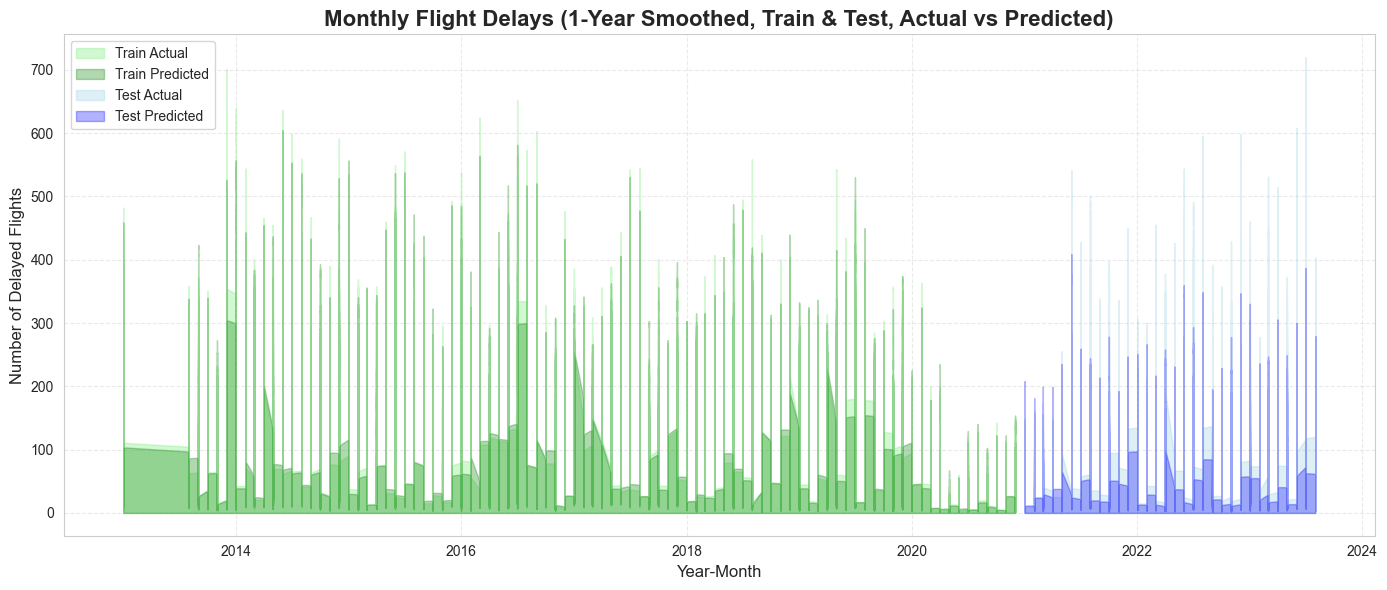

In [117]:
import matplotlib.pyplot as plt

# Reconstruct year-month for train and test
train_df['year_month'] = pd.to_datetime(
    train_df['year'].astype(str) + '-' + X_train_non_cat['month'].astype(str).str.zfill(2) + '-01'
)
test_df['year_month'] = pd.to_datetime(
    test_df['year'].astype(str) + '-' + X_test_non_cat['month'].astype(str).str.zfill(2) + '-01'
)

# Sort by time
train_df = train_df.sort_values('year_month')
test_df = test_df.sort_values('year_month')

# Apply 12-month rolling mean for smoothing
train_df['Delays_smooth'] = train_df['Delays'].rolling(window=12, center=True, min_periods=1).mean()
train_df['Predicted_smooth'] = train_df['Predicted'].rolling(window=12, center=True, min_periods=1).mean()

test_df['Delays_smooth'] = test_df['Delays'].rolling(window=12, center=True, min_periods=1).mean()
test_df['Predicted_smooth'] = test_df['Predicted'].rolling(window=12, center=True, min_periods=1).mean()

plt.figure(figsize=(14, 6))

# Train actual area
plt.fill_between(
    train_df['year_month'],
    train_df['Delays_smooth'],
    color='lightgreen',
    alpha=0.4,
    label='Train Actual'
)
# Train predicted area
plt.fill_between(
    train_df['year_month'],
    train_df['Predicted_smooth'],
    color='green',
    alpha=0.3,
    label='Train Predicted'
)

# Test actual area
plt.fill_between(
    test_df['year_month'],
    test_df['Delays_smooth'],
    color='lightblue',
    alpha=0.4,
    label='Test Actual'
)
# Test predicted area
plt.fill_between(
    test_df['year_month'],
    test_df['Predicted_smooth'],
    color='blue',
    alpha=0.3,
    label='Test Predicted'
)

plt.title('Monthly Flight Delays (1-Year Smoothed, Train & Test, Actual vs Predicted)', fontsize=16, fontweight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_17424\794586977.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


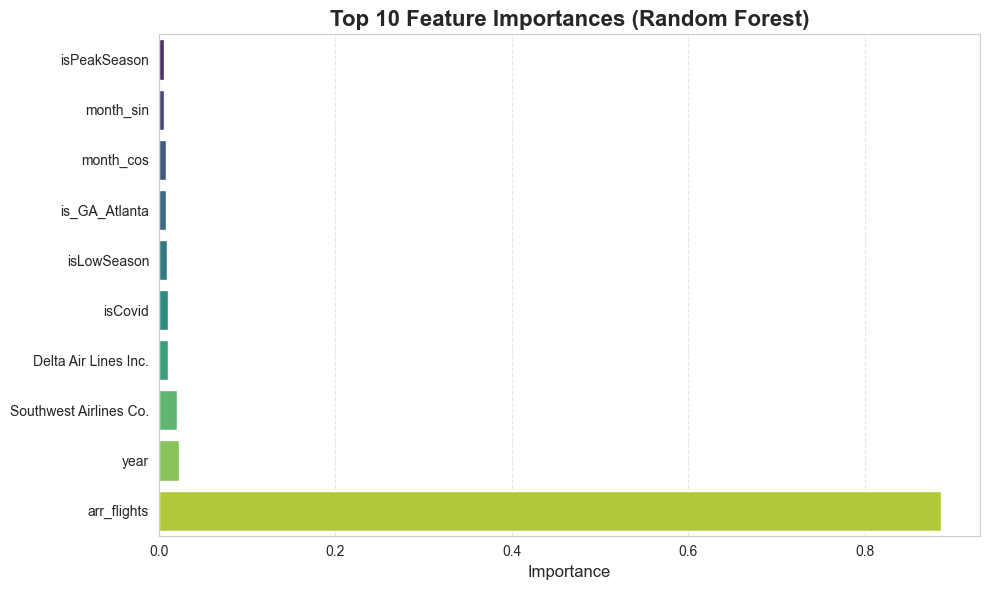

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming your RandomForest model is `rf_final` 
# and feature matrix used for importance is `X_train_non_cat` (or whatever X you used)

X_train_non_cat.drop(columns=['month'],inplace=True)

# Get feature importances
feat_importances = pd.DataFrame({
    'Feature': X_train_non_cat.columns,
    'Importance': rf_final.feature_importances_
})

# Sort by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=True).tail(10)  # top 10

plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_importances,
    palette='viridis'  # clean color
)
plt.title('Top 10 Feature Importances (Random Forest)', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Conclusion & Business Impact

This project demonstrates that machine learning can reliably forecast **monthly flight delay volumes** using historical operational data. Among the evaluated models, a **Random Forest regressor** achieved the strongest generalization performance, explaining **80.1% of the variance** in unseen test data while maintaining a **mean absolute error of approximately 25 flights per month**.

The results indicate that the model performs particularly well during **normal operating conditions**, with a **median absolute error of just 5.5 flights**, while larger errors are driven by **rare, high-impact disruption events** such as severe weather or systemic operational shocks. This behavior is consistent with real-world aviation dynamics and highlights the inherent difficulty of predicting extreme outliers.

From a business perspective, this forecasting capability enables **actionable, medium-term planning**:

* **Operational Planning:** Airlines and airports can anticipate higher delay volumes **1 month in advance**, allowing for proactive staffing and schedule adjustments.
* **Customer Experience:** Improved forecasting supports earlier deployment of customer service resources during high-risk periods.
* **Cost Management:** More accurate delay estimates enable better budgeting for delay-related operational and compensation costs.
* **Decision Support:** The model provides a data-driven foundation for evaluating capacity constraints and seasonal risk patterns.

**Additionally, looking at the resulting feature importance highlights the need to be sure about the count of incoming flights, as well as accounting for delay at specific airports and specific times of the year**.

While the model is not designed to predict unprecedented events or individual flight outcomes, it offers **meaningful decision support at the monthly planning level**, striking a practical balance between accuracy and interpretability. Future enhancements—such as integrating weather forecasts, increasing temporal granularity, or extending to flight-level predictions—represent clear paths for further value creation.

Overall, this project reflects a **production-oriented machine learning workflow**, emphasizing robust evaluation, realistic expectations, and measurable business impact rather than overfitting or purely academic optimization.